# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using DecisionTree: print_tree
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;
random = 123

123

In [2]:
mkdir("Figures/")

LoadError: IOError: mkdir: file already exists (EEXIST)

# Data

In [3]:
data = CSV.read("data.csv")

,Class_Name,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,String,Int64,Int64,Int64,Int64
1,B,1,1,1,1
2,R,1,1,1,2
3,R,1,1,1,3
4,R,1,1,1,4
5,R,1,1,1,5
6,R,1,1,2,1
7,R,1,1,2,2
8,R,1,1,2,3
9,R,1,1,2,4


Look at class labels to see if dataset is imbalanced

In [4]:
label_counts = countmap(data[:(Class_Name)])

Dict{String,Int64} with 3 entries:
  "B" => 49
  "L" => 288
  "R" => 288

In [5]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.0784
 0.4608
 0.4608

Get data ready for training

In [6]:
schema(data)

┌────────────────┬─────────┬────────────┐
│ _.names        │ _.types │ _.scitypes │
├────────────────┼─────────┼────────────┤
│ Class_Name     │ String  │ Textual    │
│ Left_Weight    │ Int64   │ Count      │
│ Left_Distance  │ Int64   │ Count      │
│ Right_Weight   │ Int64   │ Count      │
│ Right_Distance │ Int64   │ Count      │
└────────────────┴─────────┴────────────┘
_.nrows = 625


In [7]:
coerce!(data, :Class_Name=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌────────────────┬─────────────────────────────────┬───────────────┐
│ _.names        │ _.types                         │ _.scitypes    │
├────────────────┼─────────────────────────────────┼───────────────┤
│ Class_Name     │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ Left_Weight    │ Float64                         │ Continuous    │
│ Left_Distance  │ Float64                         │ Continuous    │
│ Right_Weight   │ Float64                         │ Continuous    │
│ Right_Distance │ Float64                         │ Continuous    │
└────────────────┴─────────────────────────────────┴───────────────┘
_.nrows = 625


In [8]:
y, X = unpack(data, ==(:Class_Name), colname->true)

(CategoricalValue{String,UInt32}["B", "R", "R", "R", "R", "R", "R", "R", "R", "R"  …  "L", "L", "L", "L", "L", "L", "L", "L", "L", "B"], 625×4 DataFrame
│ Row │ Left_Weight │ Left_Distance │ Right_Weight │ Right_Distance │
│     │ Float64     │ Float64       │ Float64      │ Float64        │
├─────┼─────────────┼───────────────┼──────────────┼────────────────┤
│ 1   │ 1.0         │ 1.0           │ 1.0          │ 1.0            │
│ 2   │ 1.0         │ 1.0           │ 1.0          │ 2.0            │
│ 3   │ 1.0         │ 1.0           │ 1.0          │ 3.0            │
│ 4   │ 1.0         │ 1.0           │ 1.0          │ 4.0            │
│ 5   │ 1.0         │ 1.0           │ 1.0          │ 5.0            │
│ 6   │ 1.0         │ 1.0           │ 2.0          │ 1.0            │
│ 7   │ 1.0         │ 1.0           │ 2.0          │ 2.0            │
│ 8   │ 1.0         │ 1.0           │ 2.0          │ 3.0            │
│ 9   │ 1.0         │ 1.0           │ 2.0          │ 4.0            │
│ 10  │

Partition train and test data accoring to class labels

In [9]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.7, shuffle=true, rng=123, stratify=values(data[:Class_Name])) # gives 70:30 split

([595, 102, 55, 568, 425, 389, 146, 63, 372, 250  …  195, 500, 571, 533, 112, 396, 297, 106, 303, 261], [444, 144, 546, 43, 19, 173, 365, 423, 27, 218  …  293, 614, 90, 471, 13, 134, 296, 79, 395, 415])

In [10]:
train_counts = countmap(data[train,:Class_Name])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.0776255707762557
 0.4611872146118721
 0.4611872146118721

In [11]:
test_counts = countmap(data[test,:Class_Name])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.08021390374331551
 0.45989304812834225
 0.45989304812834225

In [12]:
first(X,5)

,Left_Weight,Left_Distance,Right_Weight,Right_Distance
,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,2.0
3,1.0,1.0,1.0,3.0
4,1.0,1.0,1.0,4.0
5,1.0,1.0,1.0,5.0


# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [13]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [14]:
@load DecisionTreeClassifier verbosity=2

import MLJModels ✔
import DecisionTree ✔
import MLJModels.DecisionTree_ ✔


┌ Info: Loading into module "Main": 
└ @ MLJModels /home/andrew/.julia/packages/MLJModels/mUBFt/src/loading.jl:70


DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 5) @108

## Decision trees
* Be sure to use some form of pruning. 
* You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

1. https://alan-turing-institute.github.io/MLJ.jl/dev/transformers/#MLJModels.UnivariateDiscretizer
1. https://alan-turing-institute.github.io/MLJ.jl/dev/getting_started/#Getting-Started-1

### No post-pruning

In [15]:
dt = DecisionTreeClassifier(post_prune=false, display_depth=14)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = false,
    merge_purity_threshold = 1.0,
    pdf_smoothing = 0.0,
    display_depth = 14) @846

In [16]:
Tree = machine(dt, X, y)

Machine{DecisionTreeClassifier} @968 trained 0 times.
  args: 
    1:	Source @069 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @739 ⏎ `AbstractArray{Multiclass{3},1}`


In [17]:
fit!(Tree, rows=train, verbosity=2)

┌ Info: Training Machine{DecisionTreeClassifier} @968.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Feature 4, Threshold 2.5
L-> Feature 2, Threshold 2.5
    L-> Feature 1, Threshold 1.5
        L-> Feature 3, Threshold 2.5
            L-> Feature 4, Threshold 1.5
                L-> Feature 2, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 1 : 1/1
                        R-> 3 : 1/1
                    R-> 1 : 1/1
                R-> 3 : 3/3
            R-> 3 : 11/11
        R-> Feature 3, Threshold 2.5
            L-> Feature 1, Threshold 2.5
                L-> Feature 4, Threshold 1.5
                    L-> Feature 2, Threshold 1.5
                        L-> Feature 3, Threshold 1.5
                            L-> 2 : 1/1
                            R-> 1 : 1/1
                        R-> 2 : 2/2
                    R-> 1 : 2/2
                R-> Feature 2, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 2 : 4/4
                        R-> Feature 1, Threshold 4.5
                           

Machine{DecisionTreeClassifier} @968 trained 1 time.
  args: 
    1:	Source @069 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @739 ⏎ `AbstractArray{Multiclass{3},1}`


In [18]:
dt_acc = evaluate!(Tree, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:05


┌───────────────┬───────────────┬─────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                              │
├───────────────┼───────────────┼─────────────────────────────────────────┤
│ cross_entropy │ 7.73          │ [7.21, 7.97, 7.28, 7.28, 7.97, 8.66]    │
│ acc           │ 0.786         │ [0.8, 0.779, 0.798, 0.798, 0.779, 0.76] │
└───────────────┴───────────────┴─────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 36.0], [2.22e-16, 2.22e-16, ..., 2.22e-16], [36.0, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [19]:
fitted_params(Tree) 
print_tree(Tree.fitresult[1])

Feature 1, Threshold 2.5
L-> Feature 3, Threshold 2.5
    L-> Feature 2, Threshold 3.5
        L-> Feature 4, Threshold 1.5
            L-> Feature 2, Threshold 1.5
                L-> Feature 1, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 1 : 1/1
                        R-> 3 : 1/1
                    R-> Feature 3, Threshold 1.5
                        L-> 2 : 1/1
                        R-> 1 : 1/1
                R-> 2 : 4/4
            R-> Feature 2, Threshold 1.5
                L-> 3 : 12/12
                R-> Feature 1, Threshold 1.5
                    L-> Feature 4, Threshold 3.5
                        L-> Feature 3, Threshold 1.5
                            L-> Feature 2, Threshold 2.5
                                L-> Feature 4, Threshold 2.5
                                    L-> 1 : 1/1
                                    R-> 3 : 1/1
                                R-> 1 : 1/1
                            R-> 3 : 3/3
    

                                        R-> 2 : 1/1
                                    R-> 1 : 1/1
                                R-> Feature 4, Threshold 4.5
                                    L-> 2 : 2/2
                                    R-> Feature 1, Threshold 4.5
                                        L-> 1 : 1/1
                                        R-> 2 : 1/1
                            R-> Feature 2, Threshold 4.5
                                L-> Feature 1, Threshold 4.5
                                    L-> 3 : 2/2
                                    R-> 1 : 1/1
                                R-> Feature 1, Threshold 4.5
                                    L-> 1 : 1/1
                                    R-> Feature 4, Threshold 4.5
                                        L-> 2 : 1/1
                                        R-> 1 : 1/1


In [20]:
fitted_params(Tree) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 124
Depth:  11,
 encoding = Dict{CategoricalValue{String,UInt32},UInt32}("B" => 0x00000001,"L" => 0x00000002,"R" => 0x00000003),)

In [21]:
report(Tree)

(classes_seen = CategoricalValue{String,UInt32}["B", "L", "R"],
 print_tree = TreePrinter object (call with display depth),)

### Using Post-pruning

In [22]:
dt2 = DecisionTreeClassifier(post_prune=true, display_depth=14, merge_purity_threshold=0.7)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.7,
    pdf_smoothing = 0.0,
    display_depth = 14) @803

In [23]:
Tree2 = machine(dt2, X, y)

Machine{DecisionTreeClassifier} @043 trained 0 times.
  args: 
    1:	Source @602 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @973 ⏎ `AbstractArray{Multiclass{3},1}`


In [24]:
fit!(Tree2, rows=train, verbosity=2, force=true)

┌ Info: Training Machine{DecisionTreeClassifier} @043.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Feature 4, Threshold 2.5
L-> Feature 2, Threshold 2.5
    L-> Feature 1, Threshold 1.5
        L-> Feature 3, Threshold 2.5
            L-> Feature 4, Threshold 1.5
                L-> Feature 3, Threshold 1.5
                    L-> 1 : 1/1
                    R-> Feature 2, Threshold 1.5
                        L-> 3 : 1/1
                        R-> 1 : 1/1
                R-> 3 : 3/3
            R-> 3 : 11/11
        R-> Feature 3, Threshold 2.5
            L-> Feature 1, Threshold 2.5
                L-> Feature 4, Threshold 1.5
                    L-> Feature 2, Threshold 1.5
                        L-> Feature 3, Threshold 1.5
                            L-> 2 : 1/1
                            R-> 1 : 1/1
                        R-> 2 : 2/2
                    R-> 1 : 2/2
                R-> Feature 2, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 2 : 4/4
                        R-> Feature 1, Threshold 4.5
                           

Machine{DecisionTreeClassifier} @043 trained 1 time.
  args: 
    1:	Source @602 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @973 ⏎ `AbstractArray{Multiclass{3},1}`


In [25]:
dt_acc = evaluate!(Tree2, resampling=CV(shuffle=true), measure=[cross_entropy, acc], verbosity=1)

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure     │ _.measurement │ _.per_fold                               │
├───────────────┼───────────────┼──────────────────────────────────────────┤
│ cross_entropy │ 7.11          │ [7.21, 5.89, 8.73, 6.94, 6.24, 7.63]     │
│ acc           │ 0.797         │ [0.8, 0.837, 0.731, 0.798, 0.827, 0.788] │
└───────────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [[[2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 36.0], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16], [2.22e-16, 2.22e-16, ..., 2.22e-16]], missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [26]:
# evaluate!(Tree2, resampling=CV(shuffle=true), measure=[tnr,tpr,fnr,fpr], verbosity=1, operation=predict_mode)

In [27]:
fitted_params(Tree2) 
# print_tree(Tree.fitresult[1])

(tree = Decision Tree
Leaves: 133
Depth:  12,
 encoding = Dict{CategoricalValue{String,UInt32},UInt32}("B" => 0x00000001,"L" => 0x00000002,"R" => 0x00000003),)

In [28]:
report(Tree2)

(classes_seen = CategoricalValue{String,UInt32}["B", "L", "R"],
 print_tree = TreePrinter object (call with display depth),)

### GridSearch / RandomSearch

In [29]:
dt = DecisionTreeClassifier(post_prune=true, display_depth=14)
Tree = machine(dt, X, y)

Machine{DecisionTreeClassifier} @580 trained 0 times.
  args: 
    1:	Source @489 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @642 ⏎ `AbstractArray{Multiclass{3},1}`


In [30]:
r = range(dt, :merge_purity_threshold, lower=0.50001, upper=1)
curve = learning_curve(Tree, 
                        range=r, 
#                         resampling=Holdout(fraction_train=0.7), 
                        resampling=CV(nfolds=6, shuffle=true), 
                        measure=cross_entropy, 
                        acceleration=CPUThreads(),
                        resolution = 1000)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @287.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 1000 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 1000 metamodels: 100%[=========================] Time: 0:00:07


(parameter_name = "merge_purity_threshold",
 parameter_scale = :linear,
 parameter_values = [0.50001, 0.5005104904904905, 0.501010980980981, 0.5015114714714715, 0.502011961961962, 0.5025124524524525, 0.503012942942943, 0.5035134334334335, 0.504013923923924, 0.5045144144144145  …  0.9954955855855856, 0.9959960760760761, 0.9964965665665666, 0.9969970570570571, 0.9974975475475476, 0.997998038038038, 0.9984985285285285, 0.998999019019019, 0.9994995095095095, 1.0],
 measurements = [7.28811137799705, 7.28511185077465, 7.17780747365816, 7.132649102456171, 7.352456636097592, 7.132640531028236, 6.734462556460055, 7.006175980516129, 7.116124242539272, 7.247344016027882  …  7.668628330956854, 8.129626217710213, 8.016302154856765, 7.898027040713598, 7.7841528610501785, 8.07571477033333, 8.479500508849997, 8.710549569036644, 8.476749924800156, 8.192339534046589],)

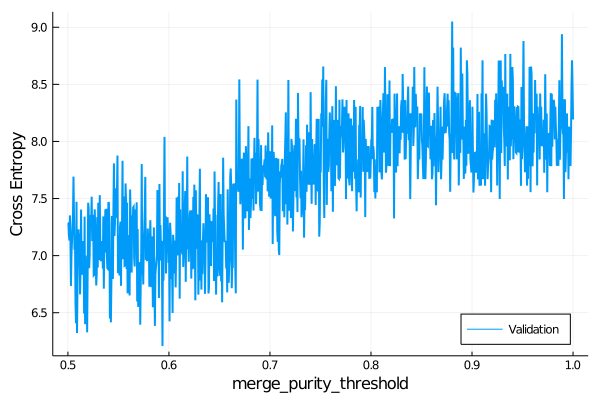

In [31]:
plot(curve.parameter_values,
     curve.measurements,
     xlab=curve.parameter_name,
     ylab="Cross Entropy",
     label="Validation", lw=2, legend=:bottomright)
# plot!(Net2.report.training_losses, label="Training", lw=2)

In [32]:
a = round(minimum(curve.measurements), digits=5)

6.2081

In [33]:
a = curve.parameter_values[argmin(curve.measurements)]

0.5936017217217218

In [34]:
param1 = :merge_purity_threshold

r1 = range(dt, param1, lower=0.50001, upper=1, scale=:linear)

MLJBase.NumericRange(Float64, :merge_purity_threshold, ... )

In [35]:
self_tuning_dt_model = TunedModel(model=dt,
                                    tuning=Grid(goal=1000),
                                    resampling=CV(nfolds=6, shuffle=true), 
                                    measure=cross_entropy,
                                    acceleration=CPUThreads(),
                                    range=[r1])

ProbabilisticTunedModel(
    model = DecisionTreeClassifier(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 0,
            post_prune = true,
            merge_purity_threshold = 1.0,
            pdf_smoothing = 0.0,
            display_depth = 14),
    tuning = Grid(
            goal = 1000,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    measure = cross_entropy(
            eps = 2.220446049250313e-16),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @828],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(no

In [36]:
self_tuning_dt = machine(self_tuning_dt_model, X, y)

Machine{ProbabilisticTunedModel{Grid,…}} @139 trained 0 times.
  args: 
    1:	Source @977 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @999 ⏎ `AbstractArray{Multiclass{3},1}`


In [37]:
z = fit!(self_tuning_dt, rows=train)

┌ Info: Training Machine{ProbabilisticTunedModel{Grid,…}} @139.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 1000 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 1000 metamodels: 100%[=========================] Time: 0:00:05


Machine{ProbabilisticTunedModel{Grid,…}} @139 trained 1 time.
  args: 
    1:	Source @977 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @999 ⏎ `AbstractArray{Multiclass{3},1}`


In [38]:
best = fitted_params(self_tuning_dt)
best

(best_model = DecisionTreeClassifier @124,
 best_fitted_params = (tree = Decision Tree
Leaves: 93
Depth:  12,
                       encoding = Dict{CategoricalValue{String,UInt32},UInt32}("B" => 0x00000001,"L" => 0x00000002,"R" => 0x00000003),),)

In [39]:
best.best_model

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.526535995995996,
    pdf_smoothing = 0.0,
    display_depth = 14) @124

In [40]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

5.67149

In [41]:
best_mpt = round(best.best_model.merge_purity_threshold,digits=5)

0.52654

In [42]:
fn = "Figures/DT_MCC"
png(replace(fn,'.' => ','))

### Learning Curve

In [43]:
dt = DecisionTreeClassifier(post_prune=true, merge_purity_threshold=best_mpt)

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.52654,
    pdf_smoothing = 0.0,
    display_depth = 5) @070

In [44]:
data_schedule, training_losses, valid_losses = learn_curve(dt, X[train,:], y[train], acc)

(d, train_metric, valid_metric) = (10, 0.7, 0.42045454545454547)
(d, train_metric, valid_metric) = (15, 1.0, 0.5568181818181818)
(d, train_metric, valid_metric) = (20, 0.85, 0.5227272727272727)
(d, train_metric, valid_metric) = (25, 1.0, 0.6477272727272727)
(d, train_metric, valid_metric) = (30, 0.7666666666666667, 0.5227272727272727)
(d, train_metric, valid_metric) = (35, 1.0, 0.7613636363636364)
(d, train_metric, valid_metric) = (40, 0.95, 0.8181818181818182)
(d, train_metric, valid_metric) = (45, 0.9777777777777777, 0.6590909090909091)
(d, train_metric, valid_metric) = (50, 0.98, 0.6477272727272727)
(d, train_metric, valid_metric) = (55, 0.9636363636363636, 0.7272727272727273)
(d, train_metric, valid_metric) = (60, 1.0, 0.7613636363636364)
(d, train_metric, valid_metric) = (65, 1.0, 0.7159090909090909)
(d, train_metric, valid_metric) = (70, 0.9857142857142858, 0.6931818181818182)
(d, train_metric, valid_metric) = (75, 0.96, 0.75)
(d, train_metric, valid_metric) = (80, 0.95, 0.761363

(10:5:350, Any[0.7, 1.0, 0.85, 1.0, 0.7666666666666667, 1.0, 0.95, 0.9777777777777777, 0.98, 0.9636363636363636  …  0.9704918032786886, 0.9483870967741935, 0.9555555555555556, 0.925, 0.963076923076923, 0.9696969696969697, 0.9462686567164179, 0.9735294117647059, 0.9739130434782609, 0.98], Any[0.42045454545454547, 0.5568181818181818, 0.5227272727272727, 0.6477272727272727, 0.5227272727272727, 0.7613636363636364, 0.8181818181818182, 0.6590909090909091, 0.6477272727272727, 0.7272727272727273  …  0.7840909090909091, 0.8522727272727273, 0.7727272727272727, 0.7840909090909091, 0.8068181818181818, 0.8295454545454546, 0.7727272727272727, 0.8068181818181818, 0.8068181818181818, 0.8181818181818182])

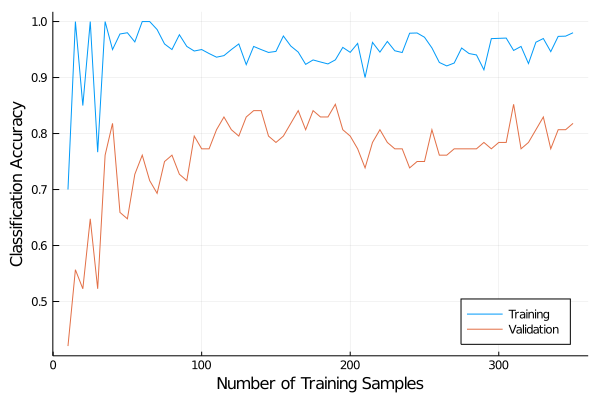

In [45]:
plot(data_schedule, training_losses, label="Training", legend=:bottomright)
plot!(data_schedule, valid_losses, label="Validation")
xlabel!("Number of Training Samples")
ylabel!("Classification Accuracy")

In [46]:
fn = "Figures/DT_LC"
png(replace(fn,'.' => ','))

# Final Results

In [47]:
final_dt = best.best_model

DecisionTreeClassifier(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = 0,
    post_prune = true,
    merge_purity_threshold = 0.526535995995996,
    pdf_smoothing = 0.0,
    display_depth = 14) @124

In [48]:
Final_Tree = machine(final_dt, X, y)

Machine{DecisionTreeClassifier} @560 trained 0 times.
  args: 
    1:	Source @346 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @582 ⏎ `AbstractArray{Multiclass{3},1}`


In [49]:
fit!(Final_Tree, rows=train, verbosity=2)

Feature 4, Threshold 2.5
L-> Feature 2, Threshold 2.5
    L-> Feature 1, Threshold 1.5
        L-> Feature 3, Threshold 2.5
            L-> Feature 4, Threshold 1.5
                L-> Feature 3, Threshold 1.5
                    L-> 1 : 1/1
                    R-> Feature 2, Threshold 1.5
                        L-> 3 : 1/1
                        R-> 1 : 1/1
                R-> 3 : 3/3
            R-> 3 : 11/11
        R-> Feature 3, Threshold 2.5
            L-> Feature 1, Threshold 2.5
                L-> Feature 4, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 2 : 2/2
                        R-> Feature 2, Threshold 1.5
                            L-> 1 : 1/1
                            R-> 2 : 1/1
                    R-> 1 : 2/2
                R-> Feature 2, Threshold 1.5
                    L-> Feature 3, Threshold 1.5
                        L-> 2 : 4/4
                        R-> Feature 1, Threshold 4.5
                           

┌ Info: Training Machine{DecisionTreeClassifier} @560.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{DecisionTreeClassifier} @560 trained 1 time.
  args: 
    1:	Source @346 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @582 ⏎ `AbstractArray{Multiclass{3},1}`


In [50]:
fitted_params(Final_Tree)

(tree = Decision Tree
Leaves: 96
Depth:  12,
 encoding = Dict{CategoricalValue{String,UInt32},UInt32}("B" => 0x00000001,"L" => 0x00000002,"R" => 0x00000003),)

In [51]:
ŷ = MLJ.predict(Final_Tree, X[test,:]);

In [52]:
cross_entropy(ŷ, y[test]) |> mean

7.929007823916347

In [53]:
acc(ŷ, y[test])

0.7700534759358288

In [54]:
c = confusion_matrix(mode.(ŷ), y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["B", "L", "R"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │      B      │      L      │      R      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      B      │      0      │     10      │     11      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      L      │      6      │     71      │      2      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      R      │      9      │      5      │     73      │
└─────────────┴─────────────┴─────────────┴─────────────┘


In [55]:
(6+9)/(6+9+0)

1.0

In [56]:
(12+5)/(12+5+69)

0.19767441860465115

In [57]:
(11+3)/(11+3+72)

0.16279069767441862

In [58]:
mcc(c)

0.6067956130401434

In [60]:
?DecisionTreeClassifier

search: DecisionTreeClassifier



DecisionTreeClassifer(; kwargs...)

CART decision tree classifier.

Inputs are tables with ordinal columns. That is, the element scitype of each column can be `Continuous`, `Count` or `OrderedFactor`. Predictions are probabilistic, but uncalibrated.

Instead of predicting the mode class at each leaf, a `UnivariateFinite` distribution is fit to the leaf training classes, with smoothing controlled by an additional hyperparameter `pdf_smoothing`: If `n` is the number of observed classes, then each class probability is replaced by `pdf_smoothing/n`, if it falls below that ratio, and the resulting vector of probabilities is renormalized. Smoothing is only applied to classes actually observed in training. Unseen classes retain zero-probability predictions.

To visualize the fitted tree in the REPL, set `verbosity=2` when fitting, or call `report(mach).print_tree(display_depth)` where `mach` is the fitted machine, and `display_depth` the desired depth. Interpretting the results will require a knowledge of the internal integer encodings of classes, which are given in `fitted_params(mach)` (which also stores the raw learned tree object from the DecisionTree.jl algorithm).

## Hyperparameters

  * `max_depth=-1`:          max depth of the decision tree (-1=any)
  * `min_samples_leaf=1`:    max number of samples each leaf needs to have
  * `min_samples_split=2`:   min number of samples needed for a split
  * `min_purity_increase=0`: min purity needed for a split
  * `n_subfeatures=0`: number of features to select at random (0 for all, -1 for square root of number of features)
  * `post_prune=false`:      set to `true` for post-fit pruning
  * `merge_purity_threshold=1.0`:  (post-pruning) merge leaves having `>=thresh`                          combined purity
  * `pdf_smoothing=0.0`:     threshold for smoothing the predicted scores
  * `display_depth=5`:       max depth to show when displaying the tree
